Running DBSCANGroup on many test cases of extended sources


to try: 
-filtering based on pt quality (sharpness, roundness etc)
-filtering of image star finder is run on 
-changing epsilon based on eclipse stats
-lower quality run of gphoton 
-changing group size 
-OPTICS with DBSCAN grouping instead of straight DBSCAN -> fix edge before using OPTICS bc it might be messing up density stats 

In [1]:
# importing dependancies 

# %matplotlib notebook

import sys
import time
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

In [2]:
# for searching for eclipses near object, don't need to run unless adding to extended source list 
from gPhoton.search.core import eclipses_near_object
galaxies = eclipses_near_object("NGC1398",4000)
#galaxies

NGC1398 position: RA 54.717208, DEC -26.337839
4 eclipses found within 4000 asec of NGC1398.


In [3]:
# array of tuples of extended source names, eclipse #s with source in them
extended_sources_eclipses = [("NGC0055",2025),("NGC5128",581),("NGC4565",26400),("NGC0205",2383), \
                             ("NGC1365",8336),("NGC1316",3239),("NGC5322",26863),("NGC3945",37289),("NGC4429",4637), \
                             ("IC152",2360),("NGC1398",13551)]

# for later testing: 
# extended_objects = [NGC7006,NGC2419,TERZAN8,NGC7492,PALOMAR12,NGC1261]

# making this markdown unless the extended source list changes so I don't accidentally run it 

# run gphoton2 on list of extended sources, get output source list 
from gPhoton.pipeline import execute_pipeline
    
    # TODO: should write something in here so that it doesn't run if the source list already exists, etc. 
for e in extended_sources_eclipses: 
        eclipse = e[1]
        execute_pipeline(
                eclipse,
                "NUV",
                depth=30,
                threads=4,
                local_root="test_data",
                recreate=False,
                aperture_sizes=[12.8, 51.2],
                write={"movie": False, "image": True},
                coregister_lightcurves=True,
                compression="rice",
                lil=True
            )

In [4]:
# reading in source files from folder 
folder = "/home/bekah/glcat/exploration_notebooks/test_source_data"

extSource_dict = {}

for file in os.listdir(folder):
    source_list = pd.read_csv("/home/bekah/glcat/exploration_notebooks/test_source_data/"+file)
    source_list = np.transpose((source_list['xcentroid'], source_list['ycentroid']))
    
    extSource_dict[file.split("_")[0]] = source_list
    
    # append the x,y vals for each source to a dictionary where the key is the eclipse # 

In [5]:
# function for reading in source images and converting to HDUL / clipping (called in loop for figure)

from gPhoton.reference import eclipse_to_paths
from gPhoton.coadd import zero_flag_and_edge

def image_reader(eclipseNum):
    # info 
    eclipse, band, depth, compression = eclipseNum, "NUV", 30, "rice"

    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/glcat/exploration_notebooks/test_data', depth, compression)

    # image to hdul 
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]

    # masking cnt image
    masked_cnt = zero_flag_and_edge(cnt, flag, edge)
    
    return masked_cnt


# clipping 
def centile_clip(image, centiles=(1, 99)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

In [7]:
# function for running DBSCANGroup 

from astropy.table import QTable, Table, Column 
from photutils.psf.groupstars import DBSCANGroup

def grouping_sources(positions, eps): 
    
    starlist = Table()

    x_0 = list(zip(*positions))[0]
    y_0 = list(zip(*positions))[1]

    starlist['x_0'] = x_0
    starlist['y_0'] = y_0

    dbscan_group = DBSCANGroup(crit_separation=eps)

    dbsc_star_groups = dbscan_group(starlist)

    dbsc_star_groups = dbsc_star_groups.group_by('group_id')

    return dbsc_star_groups 

In [8]:
# Michael's edge masks 
# threshold value set equal to minimum range of edge mask in standard
# gPhoton pipeline
def mask_margins(header, shape, threshold=1420):
    y, x = np.indices(shape)
    distances = np.sqrt(
        (y - header['CRPIX2']) ** 2 + (x - header['CRPIX1']) ** 2
    )
    return distances > threshold


def make_galex_mask(image_dict):
    mask_ix = np.nonzero(image_dict['flag'] + image_dict['edge'])
    mask = np.full(image_dict['flag'].shape, False)
    mask[mask_ix] = True
    margin = mask_margins(image_dict['header'], image_dict['cnt'].shape)
    mask += margin
    return mask

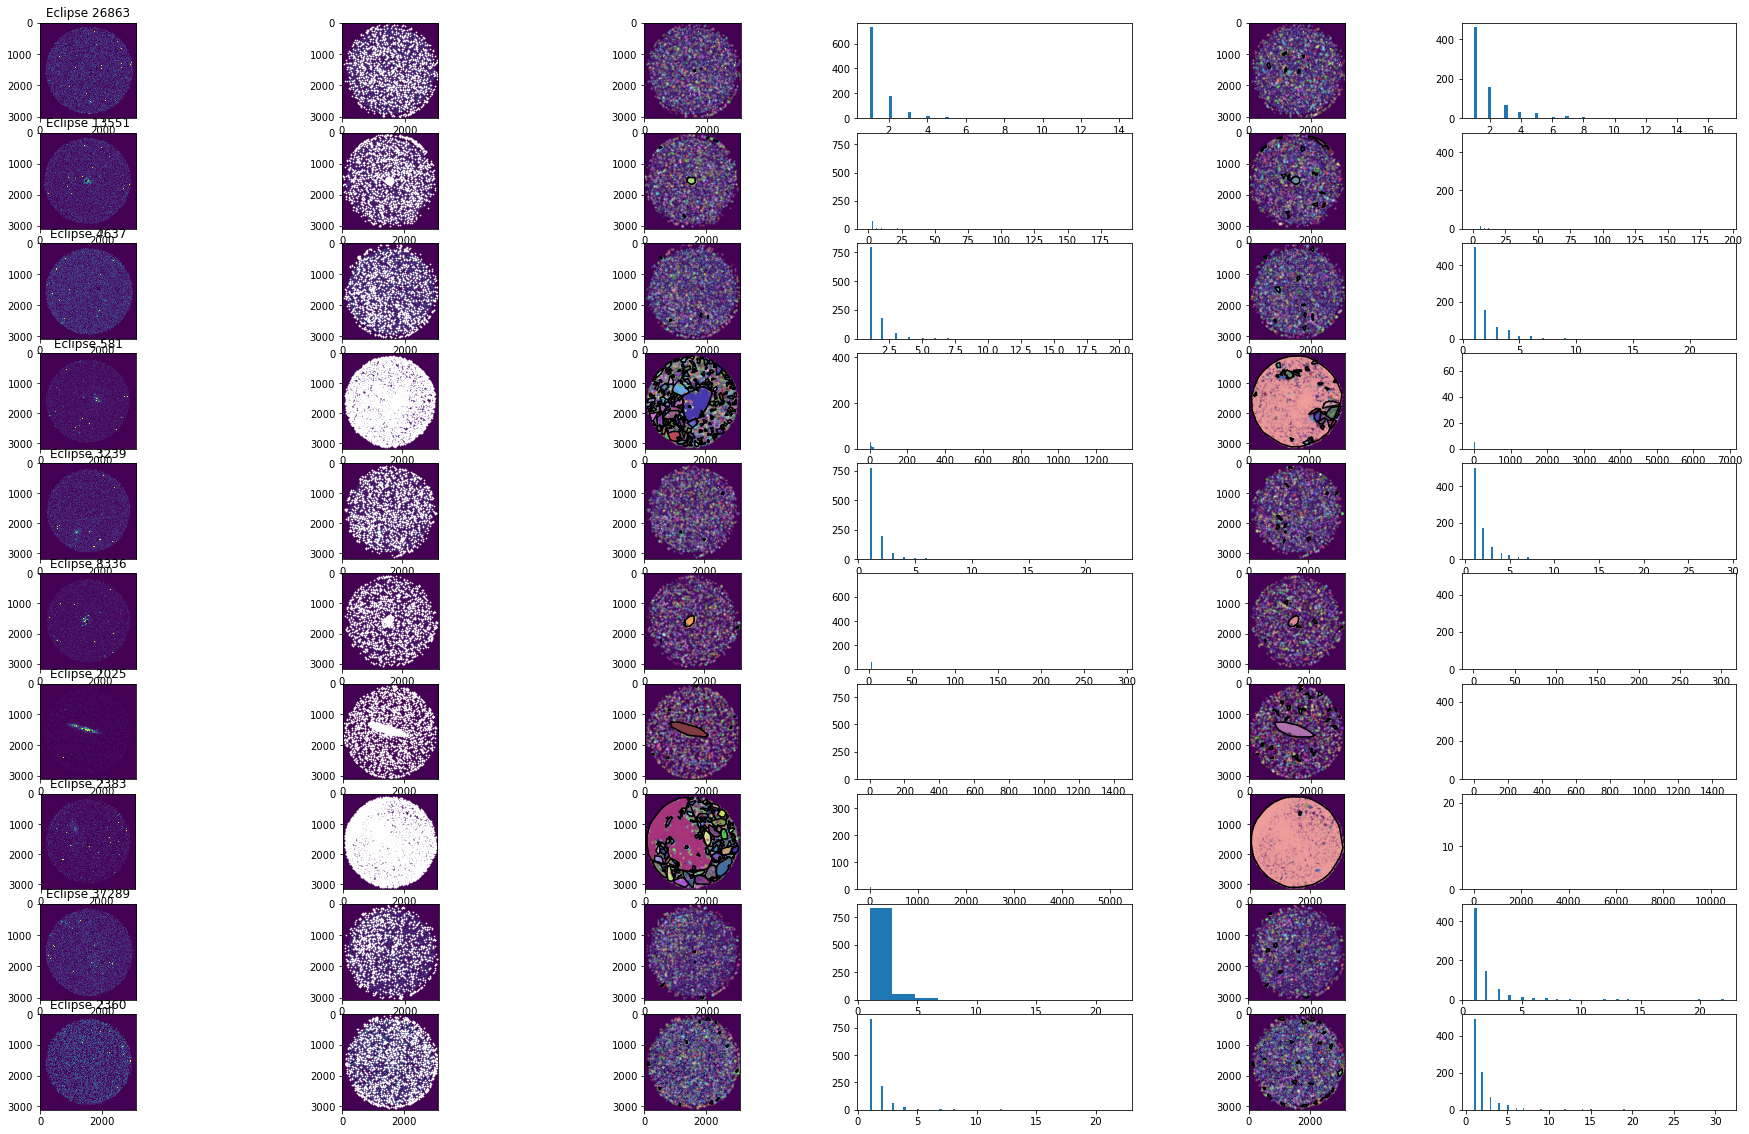

In [12]:
######### PLOT FOR COMPARING MANY ECLIPSES / SOURCES WITH SAME METHOD #########

# loop to make plot where each column is a eclipse, each row is a run of DBSCANGroup on the eclipse

# histograms exclude groups of 1 for simplicity 

import matplotlib.gridspec as gridspec
from scipy.spatial import ConvexHull, convex_hull_plot_2d

from statsmodels.distributions.empirical_distribution import ECDF


eps = 30
eps2 = 40

plt.figure(figsize=(32, len(extSource_dict)*2))
G = gridspec.GridSpec(len(extSource_dict), 6 ,wspace=0.1,hspace=0.15)

eclipseCounter = 0 

for eclipse in extSource_dict: 
    
    ax = plt.subplot(G[eclipseCounter,1]) # star finder points 
    ax2 = plt.subplot(G[eclipseCounter,0]) # just clipped eclipse image 
    ax3 = plt.subplot(G[eclipseCounter,2]) # small eps points 
    ax4 = plt.subplot(G[eclipseCounter,3]) # small eps hist 
    ax5 = plt.subplot(G[eclipseCounter,4]) # big eps points 
    ax6 = plt.subplot(G[eclipseCounter,5]) # big eps hist 
    
    eclipseCounter = eclipseCounter + 1
   
    ax.imshow(centile_clip(image_reader(eclipse),centiles=(0,99.9)),interpolation='none')
    ax2.imshow(centile_clip(image_reader(eclipse),centiles=(0,99.9)),interpolation='none')
    ax3.imshow(centile_clip(image_reader(eclipse),centiles=(0,99.9)),interpolation='none')
    ax5.imshow(centile_clip(image_reader(eclipse),centiles=(0,99.9)),interpolation='none')

    cmap = make_random_cmap(ncolors=4000,seed=34)

    dbsc_star_groups = grouping_sources(extSource_dict[str(eclipse)], eps)
    dbsc_star_groups2 = grouping_sources(extSource_dict[str(eclipse)], eps2)
    
    # histograms for counts of stars in each group for eps val   
    
    dbsc_star_groups_pd = dbsc_star_groups.to_pandas().groupby(['group_id'])
    dbsc_star_groups_count = dbsc_star_groups_pd.size()
    #ax4.hist(dbsc_star_groups_count,bins="auto")
    ecdf = ECDF(dbsc_star_groups_count)
    ax4.plot(ecdf.x, ecdf.y)

    dbsc_star_groups_pd2 = dbsc_star_groups2.to_pandas().groupby(['group_id'])
    dbsc_star_groups_count2 = dbsc_star_groups_pd2.size()
    #ax6.hist(dbsc_star_groups_count2,bins="auto")
    ecdf2 = ECDF(dbsc_star_groups_count2)
    ax6.plot(ecdf2.x, ecdf2.y)

    for i in enumerate(dbsc_star_groups):
        xypos = np.transpose([i[1]['x_0'], i[1]['y_0']])
       # ap = CircularAperture(xypos, r=fwhm_db)
        ax.scatter(xypos[0], xypos[1], color="white", alpha=1, s=.5)
        
    for i, group in enumerate(dbsc_star_groups.groups):
        xypos = np.transpose([group['x_0'], group['y_0']])
       # ap = CircularAperture(xypos, r=fwhm_db)
        ax3.scatter(xypos[:, 0], xypos[:, 1], color=cmap.colors[i], alpha=0.3, s=2)

        if len(group) > 8: 
            xypos = np.transpose([group['x_0'], group['y_0']])
            hull = ConvexHull(xypos)
            for simplex in hull.simplices:
                ax3.plot(xypos[simplex, 0], xypos[simplex, 1], 'k-')
                
    for i, group in enumerate(dbsc_star_groups2.groups):
        xypos = np.transpose([group['x_0'], group['y_0']])
       # ap = CircularAperture(xypos, r=fwhm_db)
        ax5.scatter(xypos[:, 0], xypos[:, 1], color=cmap.colors[i], alpha=0.3, s=2)

        if len(group) > 8: 
            xypos = np.transpose([group['x_0'], group['y_0']])
            hull = ConvexHull(xypos)
            for simplex in hull.simplices:
                ax5.plot(xypos[simplex, 0], xypos[simplex, 1], 'k-')
           
    # add feature name to title from tuples in array
    ax2.set_title(f"Eclipse {eclipse}")
    
plt.show()


In [ ]:
### for looking at effects on a single eclipse (much faster than running all of them at once)

import matplotlib.gridspec as gridspec
from scipy.spatial import ConvexHull, convex_hull_plot_2d

from statsmodels.distributions.empirical_distribution import ECDF

eclipse = 13551 # eclipse as an int 

eps = 30
eps2 = 40

plt.figure(figsize=(4, 18))
G = gridspec.GridSpec(6, 1 ,wspace=0.1,hspace=0.15)

eclipseCounter = 0 
    
ax = plt.subplot(G[1]) # star finder points 
ax2 = plt.subplot(G[0]) # just clipped eclipse image 
ax3 = plt.subplot(G[2]) # small eps points 
ax4 = plt.subplot(G[3]) # small eps hist 
ax5 = plt.subplot(G[4]) # big eps points 
ax6 = plt.subplot(G[5]) # big eps hist 

eclipseCounter = eclipseCounter + 1

ax.imshow(centile_clip(image_reader(eclipse),centiles=(0,99.9)),interpolation='none')
ax2.imshow(centile_clip(image_reader(eclipse),centiles=(0,99.9)),interpolation='none')
ax3.imshow(centile_clip(image_reader(eclipse),centiles=(0,99.9)),interpolation='none')
ax5.imshow(centile_clip(image_reader(eclipse),centiles=(0,99.9)),interpolation='none')

cmap = make_random_cmap(ncolors=4000,seed=34)

dbsc_star_groups = grouping_sources(extSource_dict[str(eclipse)], eps)
dbsc_star_groups2 = grouping_sources(extSource_dict[str(eclipse)], eps2)

# histograms for counts of stars in each group for eps val   

dbsc_star_groups_pd = dbsc_star_groups.to_pandas().groupby(['group_id'])
dbsc_star_groups_count = dbsc_star_groups_pd.size()
#ax4.hist(dbsc_star_groups_count,range=(2,),bins=20)
ecdf = ECDF(dbsc_star_groups_count)
ax4.plot(ecdf.x, ecdf.y)

dbsc_star_groups_pd2 = dbsc_star_groups2.to_pandas().groupby(['group_id'])
dbsc_star_groups_count2 = dbsc_star_groups_pd2.size()
#ax6.hist(dbsc_star_groups_count2,range=(2,),bins=20)
ecdf2 = ECDF(dbsc_star_groups_count2)
ax6.plot(ecdf2.x, ecdf2.y)

for i in enumerate(dbsc_star_groups):
    xypos = np.transpose([i[1]['x_0'], i[1]['y_0']])
    # ap = CircularAperture(xypos, r=fwhm_db)
    ax.scatter(xypos[0], xypos[1], color="white", alpha=1, s=.5)

    for i, group in enumerate(dbsc_star_groups.groups):
        xypos = np.transpose([group['x_0'], group['y_0']])
        # ap = CircularAperture(xypos, r=fwhm_db)
        ax3.scatter(xypos[:, 0], xypos[:, 1], color=cmap.colors[i], alpha=0.3, s=2)

    if len(group) > 8: 
        xypos = np.transpose([group['x_0'], group['y_0']])
        hull = ConvexHull(xypos)
        for simplex in hull.simplices:
            ax3.plot(xypos[simplex, 0], xypos[simplex, 1], 'k-')

    for i, group in enumerate(dbsc_star_groups2.groups):
        xypos = np.transpose([group['x_0'], group['y_0']])
        # ap = CircularAperture(xypos, r=fwhm_db)
        ax5.scatter(xypos[:, 0], xypos[:, 1], color=cmap.colors[i], alpha=0.3, s=2)

    if len(group) > 8: 
        xypos = np.transpose([group['x_0'], group['y_0']])
        hull = ConvexHull(xypos)
        for simplex in hull.simplices:
            ax5.plot(xypos[simplex, 0], xypos[simplex, 1], 'k-')

    # add feature name to title from tuples in array
    ax2.set_title(f"Eclipse {eclipse}")

plt.show()
